# Rental Prices in the USA
I am passionate about social justice in many forms, but recently have been especially interested in housing. As a renter, I have seen firsthand how difficult it can be to find affordable housing in a good condition. The book *Evicted* by Matthew Desmond opened my eyes to the horrors of eviction and the lack of tenant protections. 

I am curious to look more into housing data and will begin with a simple notebook looking at median rental price estimates by county, downloaded from HUD: https://www.huduser.gov/portal/datasets/50per.html

This notebook is for a project for Exploratory Data Analysis for Machine Learning, an IBM course on Coursera.


## Load data
Here I'll load the data and get a first look at what it contains
Note: I had to first convert the downloaded Excel file to a CSV since pandas had an error when I tried to read the excel file. Not sure why but this works

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt 
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
sns.set(font_scale = 1.3)


In [3]:
rent2024 = pd.read_csv('Rent2024 - fy2024_fmr_50.csv')

In [4]:
rent2024.head()

,state_code,county_code,county_sub_code,cntyname,town_name,hud_areaname,fips2010,rent_50_0,rent_50_1,rent_50_2,rent_50_3,rent_50_4,hud_area_code,pop2020,state_alpha
0,48,59,99999,Callahan County,NaN,"Abilene, TX MSA",4805999999,894,910,1160,1545,1857,METRO10180M10180,13959,TX
1,48,253,99999,Jones County,NaN,"Abilene, TX MSA",4825399999,894,910,1160,1545,1857,METRO10180M10180,19874,TX
2,48,441,99999,Taylor County,NaN,"Abilene, TX MSA",4844199999,894,910,1160,1545,1857,METRO10180M10180,137521,TX
3,72,3,99999,Aguada Municipio,NaN,"Aguadilla-Isabela, PR MSA",7200399999,480,484,554,674,761,METRO10380M10380,37307,PR
4,72,5,99999,Aguadilla Municipio,NaN,"Aguadilla-Isabela, PR MSA",7200599999,480,484,554,674,761,METRO10380M10380,51552,PR


In [5]:
rent2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4764 entries, 0 to 4763
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   state_code       4764 non-null   int64 
 1   county_code      4764 non-null   int64 
 2   county_sub_code  4764 non-null   int64 
 3   cntyname         4764 non-null   object
 4   town_name        1605 non-null   object
 5   hud_areaname     4764 non-null   object
 6   fips2010         4764 non-null   int64 
 7   rent_50_0        4764 non-null   int64 
 8   rent_50_1        4764 non-null   int64 
 9   rent_50_2        4764 non-null   int64 
 10  rent_50_3        4764 non-null   int64 
 11  rent_50_4        4764 non-null   int64 
 12  hud_area_code    4764 non-null   object
 13  pop2020          4764 non-null   int64 
 14  state_alpha      4764 non-null   object
dtypes: int64(10), object(5)
memory usage: 558.4+ KB


#### Takeaways:
- There are 4764 entries in fifteen rows. Apparently all are non-null except for the town_name (since some of these are probably areas in counties outside of towns).
- From reading the README associated with this data, I believe that the different rent columns correspond to the number of bedrooms. 
- The different codes (state_code, county_code, county_sub_code, fips2010, and hud_area_code) don't mean anything to me right now.

#### Drop some columns:

I'll drop the columns I don't care about.

In [6]:
rent2024.drop(columns=['state_code', 'county_code', 'county_sub_code', 'fips2010', 'hud_area_code'],inplace=True)

#### Rename some columns:
I want to have easier to read column names, partly because I'm a bit lazy and want them to make good labels on plots later :)

In [7]:
rent2024.rename(columns={"rent_50_0": "Studio", "rent_50_1": "One Bedroom",
                        "rent_50_2": "Two Bedrooms", "rent_50_3": "Three Bedrooms", 
                        "rent_50_4": "Four Bedrooms","pop2020": "Population"},inplace=True)


## Basic Visualization
I'll make a few basic plots to get a feel for the data.

### Rental distributions
First, what are the overall rental price distributions for the different types of units?

In [8]:
rentcolumns=['Studio','One Bedroom','Two Bedrooms','Three Bedrooms', 'Four Bedrooms']

Text(0, 0.5, 'Median Rent ($)')

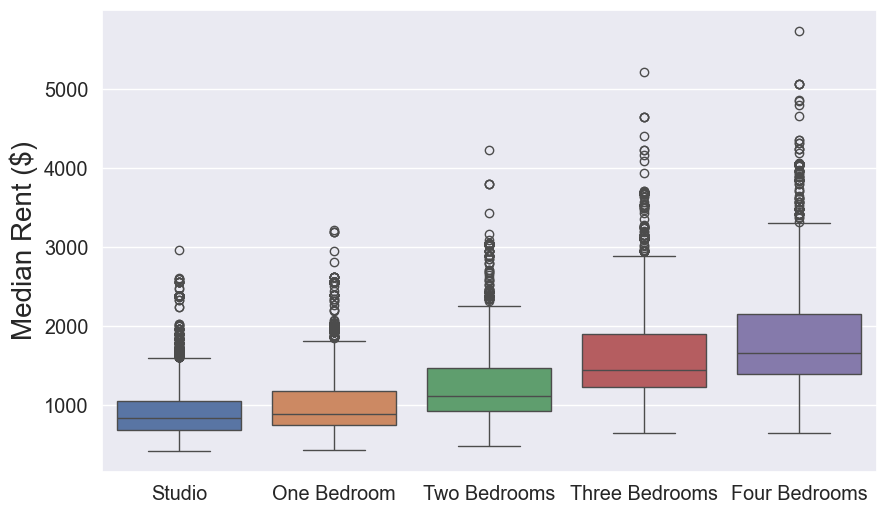

In [9]:
fig = plt.figure(figsize=[10,6])
sns.boxplot(data=rent2024[rentcolumns])
plt.ylabel('Median Rent ($)',fontsize=20)

Text(0.5, 0, 'Median Rent ($)')

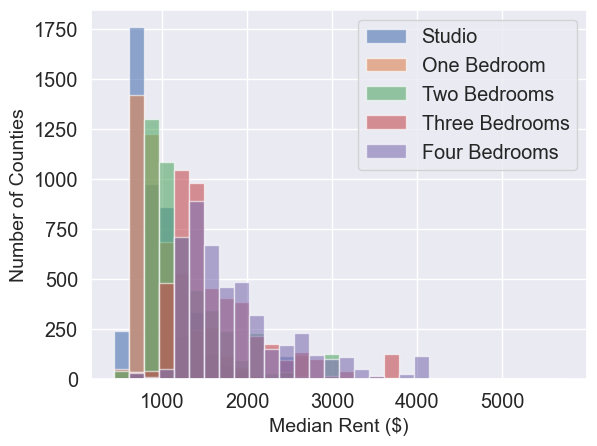

In [10]:
rent2024[rentcolumns].plot(kind='hist',bins=30,alpha=0.6)
plt.ylabel('Number of Counties',fontsize=14)
plt.xlabel('Median Rent ($)',fontsize=14)

#### Takeaways:
- It's easy enough to see the difference in rental distributions for more bedrooms
- The distributions seem to be left-skewed rather than normal
- Are there really counties/areas where the MEDIAN rental price for a **STUDIO** is over $2000 (and up to 3000)?! I hope I'm just misunderstanding something about this data set...

#### Testing for Skew
I want to test the skew of the rent data. Later on I will see if I can apply a transform to get a more normal distribution. 

In [11]:
rent2024[rentcolumns].skew()

Studio            1.928504
One Bedroom       1.890830
Two Bedrooms      1.773184
Three Bedrooms    1.650916
Four Bedrooms     1.426612
dtype: float64

### Rent vs Population
Let's see how the rent compares to population. For simplicity I'll just focus on the one bedroom units.

Text(0.5, 0, 'Area Population')

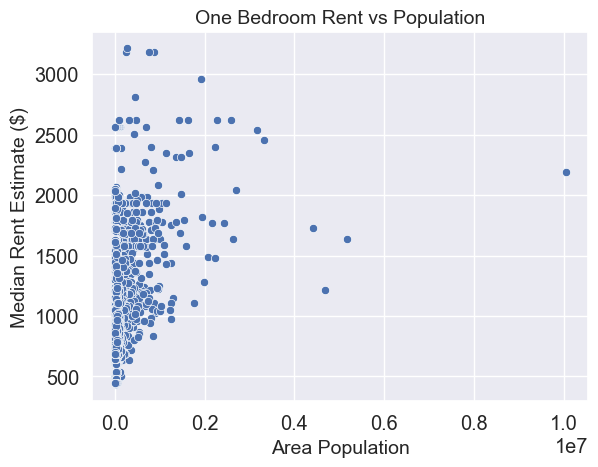

In [12]:
ax = sns.scatterplot(x=rent2024['Population'],y=rent2024[rentcolumns[1]])
ax.set_ylabel('Median Rent Estimate ($)', fontsize=14)
ax.set_title('One Bedroom Rent vs Population', fontsize=14)
ax.set_xlabel('Area Population', fontsize=14)


Interesting. It's a bit hard to see the structure since the scale is thrown by the few large population outliers. There does seem to be some relationship though. The smallest rent estimates seem to be limited to small population areas. However, there are also some very high rent low population areas. 

Next I'll set a log scale on the population to see if I can discern anything else.

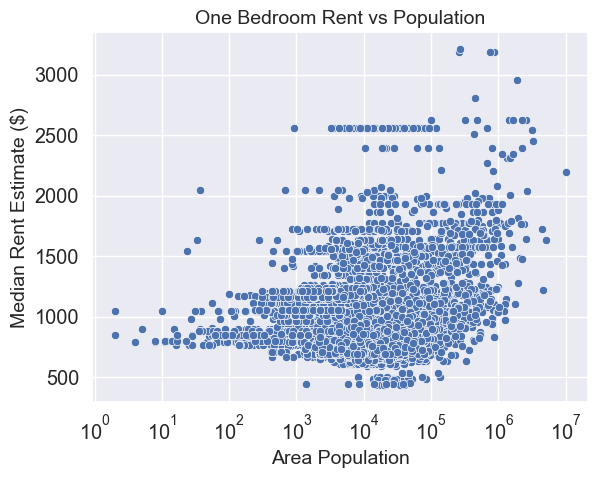

In [13]:
ax = sns.scatterplot(x=rent2024['Population'],y=rent2024[rentcolumns[1]])
ax.set_ylabel('Median Rent Estimate ($)', fontsize=14)
ax.set_title('One Bedroom Rent vs Population', fontsize=14)
ax.set_xlabel('Area Population', fontsize=14)
ax.set_xscale('log')

Interesting shape here! 
- There are quite a few *very* low population entries (<1000 people) where the median rent is low, but not actually the lowest! The lowest rent areas are a clump of small-city sized areas (10,000-100,000, although note that I don't actually know if these are cities because I'm not sure how the areas are divided up).
- But there are also areas of around the same population that have very high rent (>$2500). I wonder what causes this difference.

Because of curiosity I'm going to focus on that range and see what the rent distribution is.

In [14]:
mid_population = rent2024[(rent2024['Population']>1E4) & (rent2024['Population']<1E5)]

array([[<Axes: title={'center': 'One Bedroom'}>]], dtype=object)

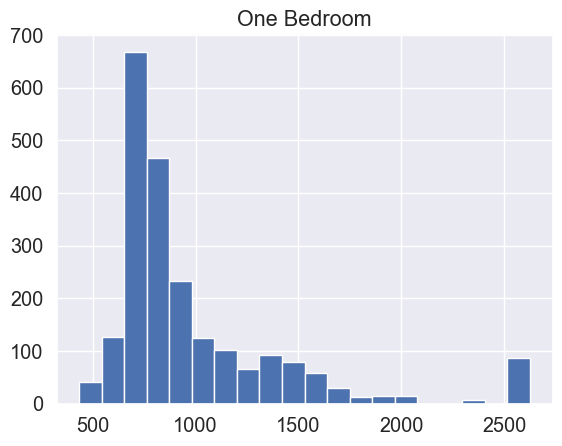

In [15]:
mid_population.hist('One Bedroom',bins=20)

So it's still the vast majority of these are lower rent, the >$2500 areas seem to be outliers. Let's see where these are!

In [16]:
mid_population[mid_population['One Bedroom']>2500].sample(5)

,cntyname,town_name,hud_areaname,Studio,One Bedroom,Two Bedrooms,Three Bedrooms,Four Bedrooms,Population,state_alpha
298,Middlesex County,Sudbury town,"Boston-Cambridge-Quincy, MA-NH HUD Metro FMR Area",2383,2560,3045,3682,4055,19248,MA
339,Plymouth County,Hull town,"Boston-Cambridge-Quincy, MA-NH HUD Metro FMR Area",2383,2560,3045,3682,4055,10478,MA
340,Plymouth County,Kingston town,"Boston-Cambridge-Quincy, MA-NH HUD Metro FMR Area",2383,2560,3045,3682,4055,13746,MA
280,Middlesex County,Hudson town,"Boston-Cambridge-Quincy, MA-NH HUD Metro FMR Area",2383,2560,3045,3682,4055,19863,MA
329,Norfolk County,Stoughton town,"Boston-Cambridge-Quincy, MA-NH HUD Metro FMR Area",2383,2560,3045,3682,4055,28742,MA


Hmmm I see 5 towns in the Boston metro area in that sample. Let's see what all the unique area names are here!

In [17]:
mid_population[mid_population['One Bedroom']>2500]['hud_areaname'].unique()

array(['Boston-Cambridge-Quincy, MA-NH HUD Metro FMR Area',
       'New York, NY HUD Metro FMR Area'], dtype=object)

Aha! Boston and New York Metro Areas! So all of these small-population high rent rows aren't tiny lil isolated towns but part of huge cities' metropolitan areas. 
Maybe I should do some grouping by the hud_areaname column to account for effects like that...

In [18]:
rent_areas = rent2024.groupby('hud_areaname').agg(OneBedroom = ('One Bedroom', 'mean'),
                                                  TwoBedroom = ('Two Bedrooms', 'mean'),
                                                  Population = ('Population', 'sum'))

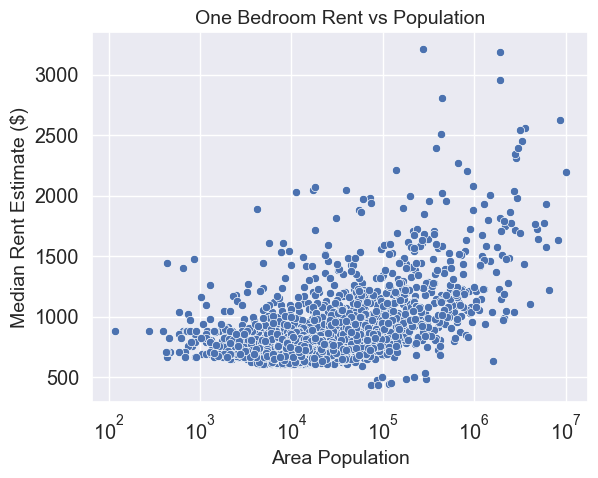

In [19]:
ax = sns.scatterplot(x=rent_areas['Population'],y=rent_areas['OneBedroom'])
ax.set_ylabel('Median Rent Estimate ($)', fontsize=14)
ax.set_title('One Bedroom Rent vs Population', fontsize=14)
ax.set_xlabel('Area Population', fontsize=14)
ax.set_xscale('log')

This seems like a smoother plot than before! There's still a little cluster of lower median rent mid-population areas, but besides that I'm seeing at least some relationship between population and rent (though far from perfectly correlated!).

## Hypothesis Testing
I'm going to practice statistical hypothesis testing with this data.

Potential hypotheses to test:
1. Rent for two bedrooms is higher than for a one bedroom: (or test any other numbers of bedrooms) very basic and shouldn’t be surprising but will be useful practice to test
2. Rent in higher population areas is higher than in lower population areas: I would need to think a bit more carefully about how to define this hypothesis - specifically how to group the population ranges
3. Rent in CA is more expensive than in TX: Interesting to me since I have lived in CA and TX. California rent is notoriously high so I don’t expect to be surprised here, but I’m interested to visualize and compare
4. Rent in 2024 is higher than in 2023: This is a hypothesis that would require a further data set to test, but would be fairly straightforward assuming the HUD page kept their data in similar format in previous years.


### Hypothesis definition:
For now I'm just going to test the first hypothesis.
I'll define the null hypothesis as there is no significant rent difference between one bedroom and two bedrooms.
The alternative hypothesis is that there is a difference.

### Test statistic:
The test statistic will be the median rent distributions, in the data set aggregated by HUD areas.

### Decision criteria:
I'll go with the 5% since that seems to be standard. If the p-value is lower, we'll reject the null hypothesis.

### Skew Correction
Now that I've aggregated my data by area, let me check again for the skew:

In [20]:
rent_areas[['OneBedroom','TwoBedroom']].skew()

OneBedroom    3.044784
TwoBedroom    3.065817
dtype: float64

The skew is even higher than before, so let me see if I can apply a transform to make a more normal distribution before testing.

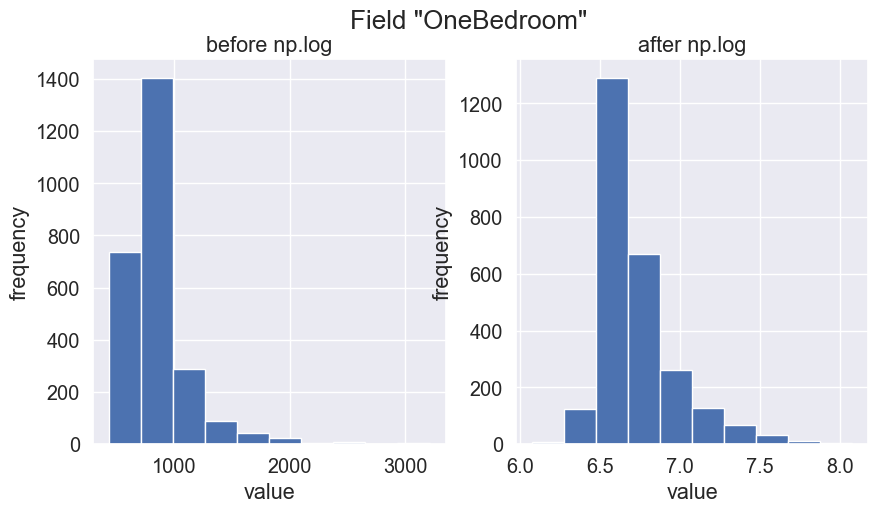

In [21]:
#First I'll apply log1p to the One Bedroom column and see what happens visually:
# Choose a field
field = "OneBedroom"

# Create two "subplots" and a "figure" using matplotlib
fig, (ax_before, ax_after) = plt.subplots(1, 2, figsize=(10, 5))

# Create a histogram on the "ax_before" subplot
rent_areas[field].hist(ax=ax_before)

# Apply a log transformation (numpy syntax) to this column
rent_areas[field].apply(np.log).hist(ax=ax_after)

# Formatting of titles etc. for each subplot
ax_before.set(title='before np.log', ylabel='frequency', xlabel='value')
ax_after.set(title='after np.log', ylabel='frequency', xlabel='value')
fig.suptitle('Field "{}"'.format(field));

In [22]:
rent_areas[field].apply(np.log1p).skew()

1.6795998441353746

That is lower skew but I wonder if I can lower it even more by using a different transform. I read about the "Box-Cox" transformation and I'm wondering if it might be more suitable here. It's worth a try at least!

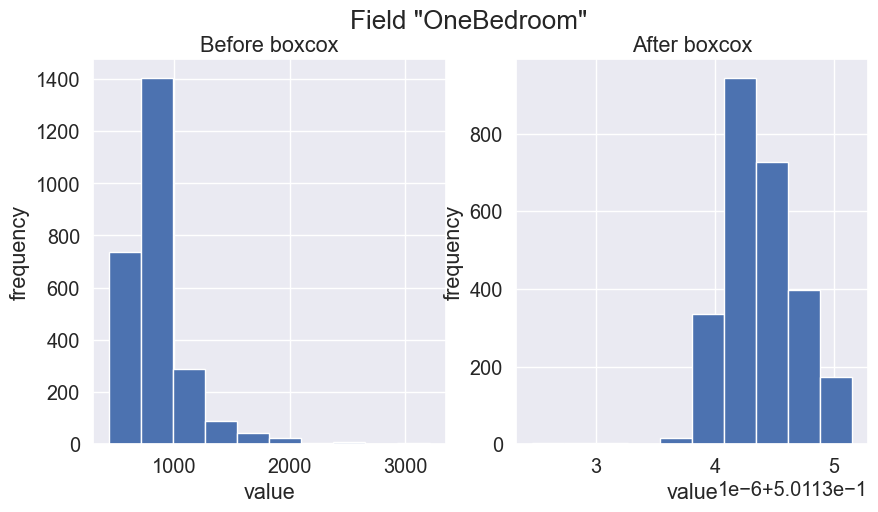

In [23]:
# Create two "subplots" and a "figure" using matplotlib
fig, (ax_before, ax_after) = plt.subplots(1, 2, figsize=(10, 5))

# Create a histogram on the "ax_before" subplot
rent_areas[field].hist(ax=ax_before)

# Apply a log transformation (numpy syntax) to this column
rent_areas['boxcox_1bed'], _ = stats.boxcox(rent_areas[field])
rent_areas['boxcox_1bed'].hist(ax=ax_after)

# Formatting of titles etc. for each subplot
ax_before.set(title='Before boxcox', ylabel='frequency', xlabel='value')
ax_after.set(title='After boxcox', ylabel='frequency', xlabel='value')
fig.suptitle('Field "{}"'.format(field));

In [24]:
rent_areas['boxcox_1bed'].skew()

0.0

Well that certainly seems less skewed! Does it seem suspicious to me that the skew is exactly zero? Yes definitely! 
I still need to read more about this to see if it's the best way of handling the data, so for now I'll proceed with the log transformation which I understand more, just so I can practice the hypothesis testing.

In [25]:
rent_areas['log_1bed']=rent_areas['OneBedroom'].apply(np.log)
rent_areas['log_2bed']=rent_areas['TwoBedroom'].apply(np.log)

Text(0.5, 0, 'Natural Log of Rent')

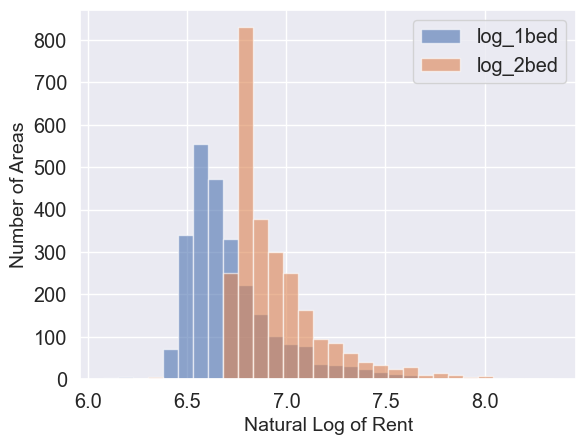

In [26]:
rent_areas[['log_1bed','log_2bed']].plot(kind='hist',bins=30,alpha=0.6)
plt.ylabel('Number of Areas',fontsize=14)
plt.xlabel('Natural Log of Rent',fontsize=14)

In [27]:
mean_1bed = rent_areas['log_1bed'].mean()
mean_2bed = rent_areas['log_2bed'].mean()

In [28]:
alpha=0.05
t_value, p_value = stats.ttest_ind(rent_areas['log_1bed'],rent_areas['log_2bed'])
print("t_value = ",t_value, ", p_value = ", p_value)

t_value =  -33.411697212028045 , p_value =  6.460569576518981e-222


### Hypothesis Test Conclusion

In [31]:
if p_value <alpha:
    print("Conclusion: since p_value {} is less than alpha {} ". format (p_value, alpha))
    print("Reject the null hypothesis that there is no difference between One Bedroom and Two Bedroom rent.")
    
else:
    print("Conclusion: since p_value {} is greater than alpha {} ". format (p_value,alpha))
    print("Fail to reject the null hypothesis that there is a difference between One Bedroom and Two Bedroom rent.")

Conclusion: since p_value 6.460569576518981e-222 is less than alpha 0.05 
Reject the null hypothesis that there is no difference between One Bedroom and Two Bedroom rent.


This is not at all surprising, but that's a relief to know that my very common sense hypothesis can be easily tested statistically.
However, some future work I could do would be to better understand different statistical tests and ways to transform the data, and which to apply for what kinds of data. This was briefly covered in the course but I would like to explore it more.